### Summary 10.06.25

Even though I’m working with just the top 1000 players by earnings, the dataset shows a great diversity in game types, but career patterns are surprisingly consistent across genres.

One thing I’ve learned starting the analysis: this dataset is full of possibilities but also full of traps.
There’s so much to analyze but it’s also easy to go down the wrong path or misread the signals. For example, the top 1000 list is frozen in time, and some games are too recent or too niche to compare fairly.

Every time I dig into a simple question, it opens up ten others (which is great) but I’ll need to be selective to keep the final story sharp and impactful.

In [ ]:
import pandas as pd
from pathlib import Path

BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR / "data_and_notebooks"

# Load the datasets
profiles_df = pd.read_csv(DATA_DIR / "players_profiles_with_id.csv")
tournaments_df = pd.read_csv(DATA_DIR / "players_tournaments_merged.csv")
games_df = pd.read_csv(DATA_DIR / "games_metadata_enriched.csv")

In [ ]:
# Calculate career length (state in June 2025) 

# AKA How long does it take to reach Top 1000 ? bad question

# Convert EndDate to datetime format
tournaments_df['EndDate'] = pd.to_datetime(tournaments_df['EndDate'], errors='coerce')

# Compute career start and end dates per player
career_span_df = tournaments_df.groupby('PlayerId')['EndDate'].agg(['min', 'max']).reset_index()
career_span_df.columns = ['PlayerId', 'FirstTournament', 'LastTournament']

# Compute career length in years (with decimals)
career_span_df['CareerLengthYears'] = (career_span_df['LastTournament'] - career_span_df['FirstTournament']).dt.days / 365.25

# Merge with total earnings from profiles
career_span_df = career_span_df.merge(
    profiles_df[['PlayerId', 'TotalUSDPrize', 'CurrentHandle']],
    on='PlayerId',
    how='left'
)

# Preview the result
career_span_df.sort_values('CareerLengthYears', ascending=False).head()


,PlayerId,FirstTournament,LastTournament,CareerLengthYears,TotalUSDPrize,CurrentHandle
47,1705,2002-08-11,2025-03-08,22.573580,613805.68,Tokido
42,1510,2003-02-08,2025-05-04,22.234086,721618.24,Edward
34,1484,2003-07-13,2025-05-18,21.848049,748924.02,TaZ
10,1072,2003-11-07,2024-12-29,21.144422,782559.43,Moon
7,1042,2004-03-13,2024-12-29,20.796715,668434.36,Lyn


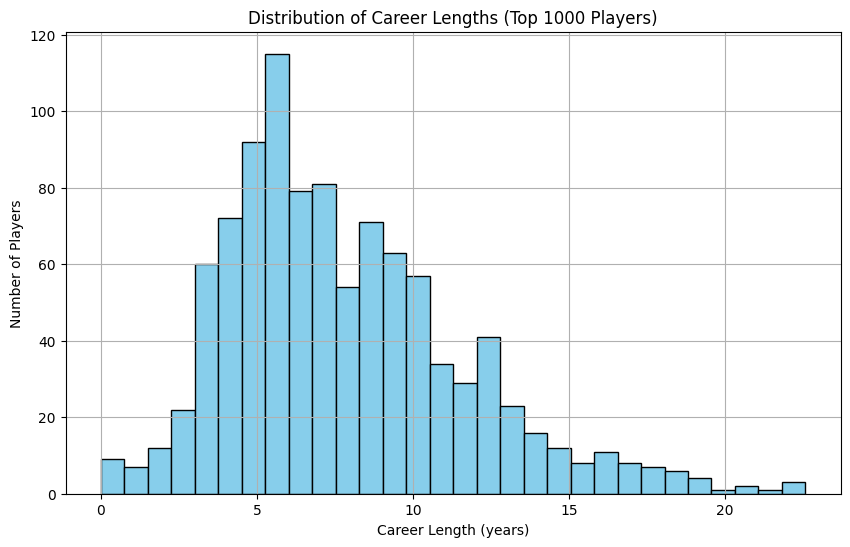

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(career_span_df['CareerLengthYears'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Career Lengths (Top 1000 Players)')
plt.xlabel('Career Length (years)')
plt.ylabel('Number of Players')
plt.grid(True)
plt.show()


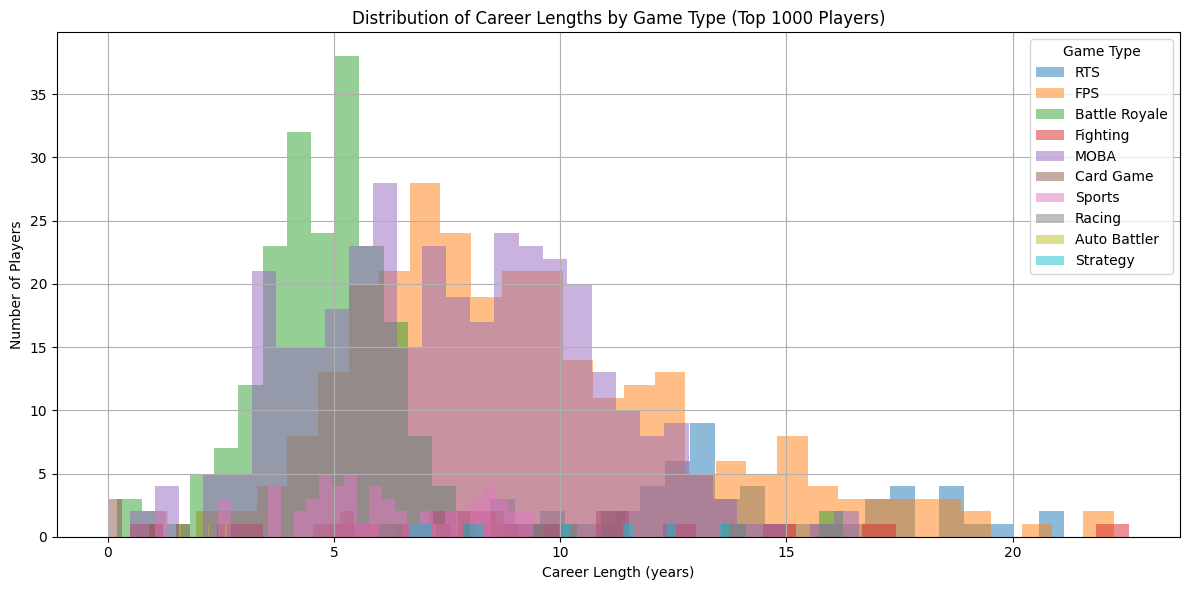

In [45]:
import matplotlib.pyplot as plt

# Filter to players with known GameType
valid_players = scatter_df.dropna(subset=['GameType'])

# Plot histogram of Career Lengths per GameType using seaborn for better visuals
plt.figure(figsize=(12, 6))
for game_type in valid_players['GameType'].unique():
    subset = valid_players[valid_players['GameType'] == game_type]
    plt.hist(subset['CareerLengthYears'], bins=30, alpha=0.5, label=game_type)

plt.title('Distribution of Career Lengths by Game Type (Top 1000 Players)')
plt.xlabel('Career Length (years)')
plt.ylabel('Number of Players')
plt.legend(title='Game Type')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/rd/n3hp3kcn0tv7s8qlt2m6g11w0000gn/T/ipykernel_4375/257710235.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




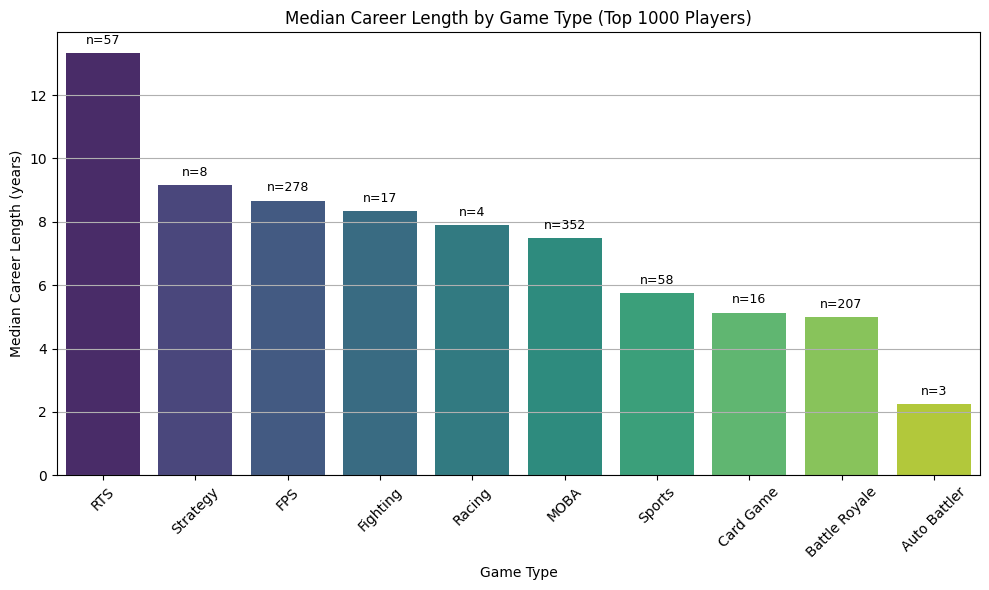

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
career_span_df['CareerLengthYears'] = career_span_df['CareerLengthYears'].astype(float)
career_by_game = career_span_df.groupby('GameType')['CareerLengthYears'].median().reset_index()
counts_by_game = career_span_df['GameType'].value_counts().reset_index()
counts_by_game.columns = ['GameType', 'PlayerCount']

# Merge median and counts
career_by_game = career_by_game.merge(counts_by_game, on='GameType')
career_by_game = career_by_game.sort_values(by='CareerLengthYears', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=career_by_game, x='GameType', y='CareerLengthYears', palette='viridis')

# Add annotations properly above each bar
for i, bar in enumerate(barplot.patches):
    height = bar.get_height()
    count = career_by_game.iloc[i]['PlayerCount']
    barplot.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.2,
        f'n={int(count)}',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.title('Median Career Length by Game Type (Top 1000 Players)')
plt.xlabel('Game Type')
plt.ylabel('Median Career Length (years)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [176]:
# Tournament count per player
mean_tn_per_game = scatter_df.groupby('GameType')['TotalTournaments'].mean().sort_values(ascending=False)
print(mean_tn_per_game)


GameType
RTS              268.245614
Strategy         115.750000
FPS               93.205036
Fighting          82.529412
Sports            77.275862
Battle Royale     62.932367
MOBA              51.411932
Card Game         36.250000
Racing            25.500000
Auto Battler       7.000000
Name: TotalTournaments, dtype: float64


In [20]:
import datetime

# Define the cutoff date to classify active vs inactive players
cutoff_date = pd.Timestamp(datetime.datetime(2024, 1, 1))

# Create a new column for career status
career_span_df['CareerStatus'] = career_span_df['LastTournament'].apply(
    lambda x: 'Ongoing' if x >= cutoff_date else 'Inactive'
)

# Display counts per status
career_span_df['CareerStatus'].value_counts()

CareerStatus
Ongoing     719
Inactive    281
Name: count, dtype: int64

<Figure size 800x600 with 0 Axes>

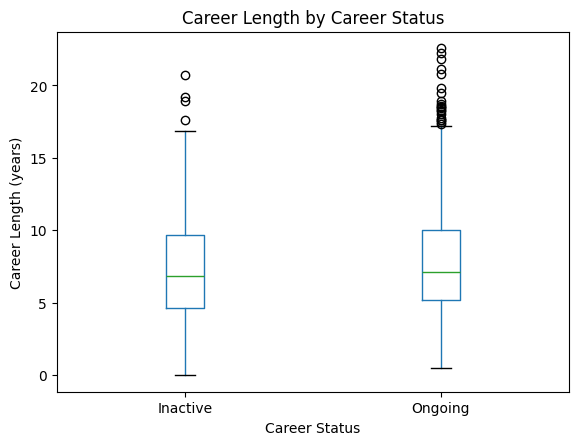

In [21]:
import matplotlib.pyplot as plt

# Prepare the plot
plt.figure(figsize=(8, 6))
career_span_df.boxplot(column='CareerLengthYears', by='CareerStatus', grid=False)

# Title and labels
plt.title('Career Length by Career Status')
plt.suptitle('')
plt.xlabel('Career Status')
plt.ylabel('Career Length (years)')

plt.show()


In [ ]:
# Career starts and ends (not relevant as dataset is fixed in time)

start_counts = career_span_df['StartYear'].value_counts().sort_index()
end_counts = career_span_df[career_span_df['CareerStatus'] == 'Inactive']['EndYear'].value_counts().sort_index()

# Create Plotly bar chart showing career starts and ends (cleaned version)
fig = go.Figure()

fig.add_trace(go.Bar(
    x=start_counts.index,
    y=start_counts.values,
    name='Career Starts',
    marker_color='green'
))

fig.add_trace(go.Bar(
    x=end_counts.index,
    y=end_counts.values,
    name='Career Ends (Inactive Players Only)',
    marker_color='red'
))

# Update layout with titles and formatting
fig.update_layout(
    title='Number of Career Starts and Ends per Year (Top 1000 Players)',
    xaxis_title='Year',
    yaxis_title='Number of Players',
    barmode='group',
    template='plotly_white'
)

fig.show()


In [95]:
# Merge the player's most played GameId to determine their main GameType 
# Step 1: Count number of tournaments played per player per GameId
game_counts = tournaments_df.groupby(['PlayerId', 'GameId']).size().reset_index(name='TournamentsPlayed')

# Step 2: For each player, select the GameId with the highest number of tournaments
main_game = game_counts.sort_values('TournamentsPlayed', ascending=False).drop_duplicates('PlayerId')

# Step 3: Merge with games metadata to get GameType
main_game = main_game.merge(games_df[['GameId', 'GameType']], on='GameId', how='left')

# Step 4: Merge GameType back into career_span_df
career_span_df = career_span_df.merge(main_game[['PlayerId', 'GameType']], on='PlayerId', how='left')

# Preview the enriched dataset
career_span_df[['PlayerId', 'CareerLengthYears', 'GameType']].head()


,PlayerId,CareerLengthYears,GameType
0,1000,15.334702,RTS
1,1002,13.968515,RTS
2,1003,8.878850,RTS
3,1007,12.380561,RTS
4,1008,16.733744,RTS


In [26]:
# Merge back TotalTournaments from profiles_df
career_span_df = career_span_df.merge(
    profiles_df[['PlayerId', 'TotalTournaments']],
    on='PlayerId',
    how='left'
)

In [ ]:
# Merge GameName from games_df into scatter_df using GameId
scatter_df = scatter_df.merge(
    games_df[['GameId', 'GameName']],
    on='GameId',
    how='left'
)

# Update the hover_data dictionary to replace GameId with GameName
hover_data = {
    'GameType': True,
    'GameName': True,
    'FirstTournamentYear': True,
    'LastTournamentYear': True,
    'TotalUSDPrize': True,
    'TotalTournaments': True
}

# Regenerate data subsets
ongoing_df = scatter_df[scatter_df['CareerStatus'] == 'Ongoing']
inactive_df = scatter_df[scatter_df['CareerStatus'] == 'Inactive']

# Scatterplot for Ongoing players
fig_ongoing = px.scatter(
    ongoing_df,
    x='FirstTournamentYear',
    y='TotalTournaments',
    color='GameType',
    color_discrete_map=game_type_palette,
    size='TotalUSDPrize',
    hover_name='CurrentHandle',
    hover_data=hover_data,
    title='Top 1000 – Ongoing Players: First Tournament Year vs Total Tournaments',
    template='plotly_white'
)

# Scatterplot for Inactive players
fig_inactive = px.scatter(
    inactive_df,
    x='FirstTournamentYear',
    y='TotalTournaments',
    color='GameType',
    color_discrete_map=game_type_palette,
    size='TotalUSDPrize',
    hover_name='CurrentHandle',
    hover_data=hover_data,
    title='Top 1000 – Inactive Players: First Tournament Year vs Total Tournaments',
    template='plotly_white'
)

# Show both figures
fig_ongoing.show()
fig_inactive.show()


Bugha
arT
Clem
Angry Bird
Collapse
Firstkiller
M0nkey M00n
BunnyHoppor
MagnusCarlsen
A
Kaydop
Punk
Th0masHD
Cat
ana


In [179]:
scatter_df.columns

Index(['PlayerId', 'FirstTournament', 'LastTournament', 'CareerLengthYears',
       'TotalUSDPrize', 'CurrentHandle', 'CareerStatus', 'StartYear',
       'EndYear', 'GameType', 'FirstTournamentYear', 'TotalTournaments',
       'GameId_x', 'LastTournamentYear', 'GameId_y', 'GameId', 'GameName',
       'RecentEarningsUSD'],
      dtype='object')

In [180]:
scatter_df.to_csv("scatter_df_export.csv", index=False)

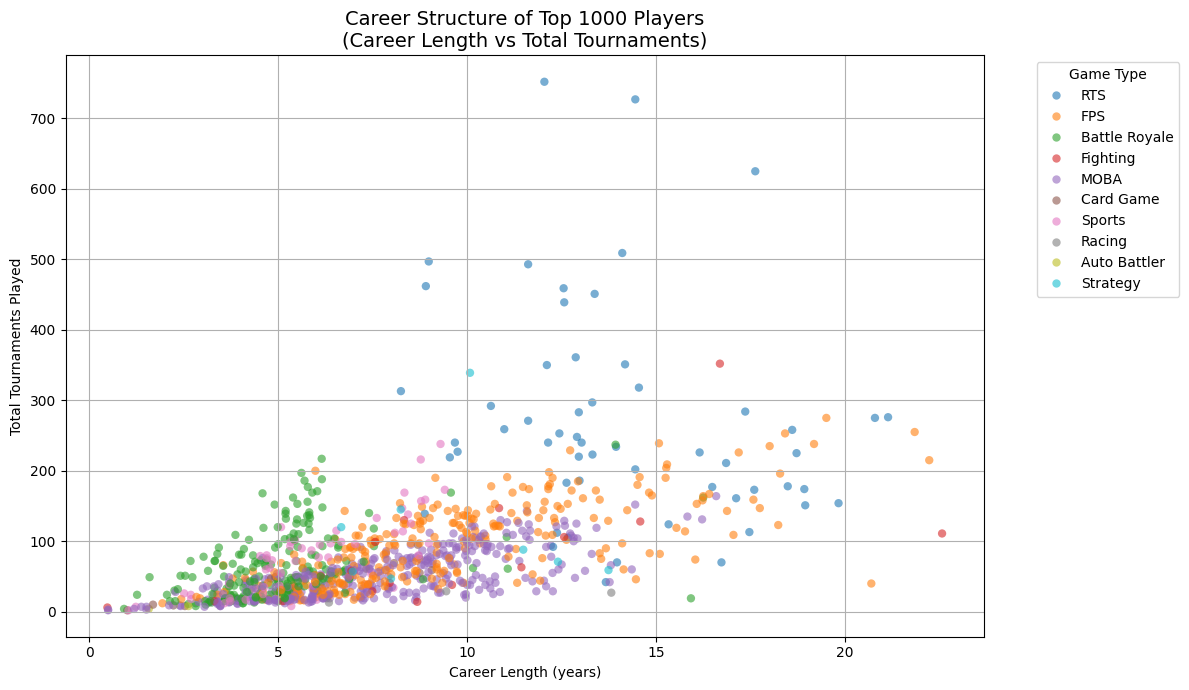

In [181]:

# Filter out entries with missing or zero values in key columns
scatter_df_filtered = scatter_df[
    (scatter_df["CareerLengthYears"] > 0.25) &
    (scatter_df["TotalTournaments"] > 0) &
    (~scatter_df["GameType"].isna())
]

# Plot the colored scatterplot
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=scatter_df_filtered,
    x="CareerLengthYears",
    y="TotalTournaments",
    hue="GameType",
    alpha=0.6,
    edgecolor="none",
    palette="tab10"
)

plt.title("Career Structure of Top 1000 Players\n(Career Length vs Total Tournaments)", fontsize=14)
plt.xlabel("Career Length (years)")
plt.ylabel("Total Tournaments Played")
plt.legend(title="Game Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [209]:
import plotly.express as px
import plotly.graph_objects as go

# Fonction de compression douce
def compress_y(val, threshold=300):
    return val if val <= threshold else threshold + (val - threshold)**0.8

# Colonne transformée
scatter_df_filtered["CompressedTournaments"] = scatter_df_filtered["TotalTournaments"].apply(compress_y)

# Scatter principal
fig = px.scatter(
    scatter_df_filtered,
    x="CareerLengthYears",
    y="CompressedTournaments",
    color="GameType",
    hover_data=["GameType", "CareerLengthYears", "TotalTournaments"],
    opacity=1,
    labels={
        "CareerLengthYears": "Career Length (years)",
        "CompressedTournaments": "Total Tournaments Played (compressed)"
    },
    title="Career Structure of Top 1000 Players<br><sup>Soft Compression Above 300 Tournaments</sup>"
)

# Appliquer layout sombre
fig.update_layout(
    paper_bgcolor='#0b132b',
    plot_bgcolor='#0b132b',
    font=dict(color='white'),
    height=700,
    xaxis=dict(
    showgrid=True,
    gridcolor='rgba(255,255,255,0.1)'
),
yaxis=dict(
    showgrid=True,
    gridcolor='rgba(255,255,255,0.1)'
)
)
tick_values_raw = [50, 100, 200, 300, 400, 500, 600, 700]
tick_values_compressed = [compress_y(val) for val in tick_values_raw]

fig.update_yaxes(
    tickvals=[50, 100, 200, 300, compress_y(400), compress_y(500), compress_y(600), compress_y(700)],
    ticktext=["50", "100", "200", "300", "400", "500", "600", "700"],
    title="Total Tournaments Played"
)

fig.show()


In [231]:
# Filter to keep only GameTypes with at least 20 players
counts = scatter_df_filtered["GameType"].value_counts()
valid_types = counts[counts >= 20].index
scatter_df_filtered = scatter_df_filtered[scatter_df_filtered["GameType"].isin(valid_types)]

# Recalculate medians
summary_df = scatter_df_filtered.groupby("GameType").agg(
    MedianCareerLength=("CareerLengthYears", "median"),
    MedianTournamentsPerYear=("TournamentsPerYear", "median"),
    Count=("PlayerId", "count")
).reset_index().sort_values("MedianCareerLength", ascending=False)


# Create grouped bar chart using Plotly
fig = go.Figure()

fig.add_trace(go.Bar(
    x=summary_df["GameType"],
    y=summary_df["MedianCareerLength"],
    name="Career Length"
))

fig.add_trace(go.Bar(
    x=summary_df["GameType"],
    y=summary_df["MedianTournamentsPerYear"],
    name="Tournaments / Year"
))
for i, row in summary_df.iterrows():
    fig.add_annotation(
        x=row["GameType"],
        y=max(row["MedianCareerLength"], row["MedianTournamentsPerYear"]) + 0.5,
        text=f"{row['Count']}<br>players",
        showarrow=False,
        font=dict(color="white", size=14),
        yanchor="bottom"
    )
# Apply saved visual style
fig.update_layout(
    title="Career Duration vs Intensity by Popular Game Type",
    title_font=dict(size=30, color='white'),
    paper_bgcolor='#0b132b',
    plot_bgcolor='#0b132b',
    font=dict(color='white', size=14),
    height=700,
    legend=dict(
        title="Metric (medians)",
        title_font=dict(size=18, color='white'),
        font=dict(size=16, color='white')
    ),
    xaxis=dict(
        title=dict(text="Game Type", font=dict(size=22, color='white')),
        tickfont=dict(size=20, color='white'),
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)'
    ),
    yaxis=dict(
        title=dict(text="Years & Tournaments per Year", font=dict(size=22, color='white')),
        tickfont=dict(size=20, color='white'),
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)'
    ),
    barmode='group'
)

fig.show()

In [233]:
scatter_df.columns

Index(['PlayerId', 'FirstTournament', 'LastTournament', 'CareerLengthYears',
       'TotalUSDPrize', 'CurrentHandle', 'CareerStatus', 'StartYear',
       'EndYear', 'GameType', 'FirstTournamentYear', 'TotalTournaments',
       'GameId_x', 'LastTournamentYear', 'GameId_y', 'GameId', 'GameName',
       'RecentEarningsUSD'],
      dtype='object')

In [237]:
# Nombre de joueurs avec moins de 10 tournois
players_with_few_tournaments = scatter_df[scatter_df["TotalTournaments"] < 10]
print(players_with_few_tournaments.shape[0])


31


In [37]:
import pandas as pd

# Load the dataset with career length info (already cleaned and prepared previously)
df = scatter_df.copy()

# Calculate the number of players with career length ≥10 years and <10 years
veteran_threshold = 10
veterans_count = (df['CareerLengthYears'] >= veteran_threshold).sum()
non_veterans_count = (df['CareerLengthYears'] < veteran_threshold).sum()
total_count = len(df)

# Calculate ratios
veteran_ratio = veterans_count / total_count
non_veteran_ratio = non_veterans_count / total_count

{
    "veterans_count": veterans_count,
    "non_veterans_count": non_veterans_count,
    "total_players": total_count,
    "veteran_ratio": round(veteran_ratio, 3),
    "non_veteran_ratio": round(non_veteran_ratio, 3)
}


{'veterans_count': np.int64(245),
 'non_veterans_count': np.int64(755),
 'total_players': 1000,
 'veteran_ratio': np.float64(0.245),
 'non_veteran_ratio': np.float64(0.755)}

In [97]:
import pandas as pd
import plotly.express as px

# Step 1: Convert prizes to USD
tournaments_df['PrizeUSD'] = tournaments_df['Prize'] * tournaments_df['ExchangeRate']
tournaments_df['EndDate'] = pd.to_datetime(tournaments_df['EndDate'], errors='coerce')
tournaments_df['Year'] = tournaments_df['EndDate'].dt.year

# Step 2: Compute earnings before and after 2020
before_2020 = tournaments_df[tournaments_df['Year'] < 2020].groupby('PlayerId')['PrizeUSD'].sum().reset_index()
before_2020.rename(columns={'PrizeUSD': 'EarningsBefore2020'}, inplace=True)

from_2020 = tournaments_df[tournaments_df['Year'] >= 2020].groupby('PlayerId')['PrizeUSD'].sum().reset_index()
from_2020.rename(columns={'PrizeUSD': 'EarningsFrom2020'}, inplace=True)

# Step 3: Merge earnings and compute ratio
earnings = pd.merge(before_2020, from_2020, on='PlayerId', how='outer').fillna(0)
earnings['RatioFrom2020'] = earnings['EarningsFrom2020'] / (
    earnings['EarningsBefore2020'] + earnings['EarningsFrom2020']
)

# Step 4: Merge with player profiles to get GameType, Career info and status
player_info = scatter_df[['PlayerId', 'GameType', 'CareerLengthYears', 'CareerStatus']].drop_duplicates('PlayerId')
merged_df = pd.merge(earnings, player_info, on='PlayerId', how='inner')

# Step 5: Filter to veterans (≥10y) AND still active
veteran_ongoing = merged_df[
    (merged_df['CareerLengthYears'] >= 10) & (merged_df['CareerStatus'] == 'Ongoing')
]

# Step 6: Optionally filter GameTypes (remove Battle Royale and Racing)
excluded_game_types = ['Battle Royale', 'Racing']
veteran_ongoing_filtered = veteran_ongoing[~veteran_ongoing['GameType'].isin(excluded_game_types)]

# Step 7: Plot
fig = px.box(
    veteran_ongoing_filtered,
    x='GameType',
    y='RatioFrom2020',
    points='all',
    title='Proportion of Earnings Since 2020 – Veterans (10+ years, Ongoing)',
    labels={
        'GameType': 'Game Type',
        'RatioFrom2020': 'Earnings from 2020 / Total Earnings'
    },
    template='plotly_white'
)
fig.update_layout(xaxis_tickangle=45)
fig.show()


In [98]:
tournaments_df['PrizeUSD'].head()

0    1000500.0
1      25000.0
2      24000.0
3      25000.0
4      32490.0
Name: PrizeUSD, dtype: float64

In [ ]:
import pandas as pd

# Load the tournaments data
tournaments_df = pd.read_csv(DATA_DIR / "players_tournaments_merged.csv")

# Convert Prize to USD
tournaments_df['PrizeUSD'] = tournaments_df['Prize'] * tournaments_df['ExchangeRate']

# Step 1: For each player, compute the top 3 highest earning tournaments and their share
top_3_earnings = (
    tournaments_df.sort_values(['PlayerId', 'PrizeUSD'], ascending=[True, False])
    .groupby('PlayerId')
    .head(3)
    .groupby('PlayerId')['PrizeUSD']
    .sum()
    .reset_index(name='Top3PrizeUSD')
)

# Step 2: Total earnings per player
total_earnings = (
    tournaments_df.groupby('PlayerId')['PrizeUSD']
    .sum()
    .reset_index(name='TotalPrizeUSD')
)

# Step 3: Merge and compute the percentage
merged_earnings = pd.merge(total_earnings, top_3_earnings, on='PlayerId')
merged_earnings['Top3Share'] = merged_earnings['Top3PrizeUSD'] / merged_earnings['TotalPrizeUSD']

import plotly.express as px

# Step 4: Plot the distribution of Top 3 Tournament Share
fig = px.histogram(
    merged_earnings,
    x='Top3Share',
    nbins=30,
    title='Distribution of Top 3 Tournament Earnings Share per Player',
    labels={'Top3Share': 'Share of Total Earnings from Top 3 Tournaments'},
    template='plotly_white'
)
fig.update_layout(yaxis_title='Number of Players')
fig.show()


In [61]:
# Merge Top3 share data with game type information
player_game_types = scatter_df[['PlayerId', 'GameType']].drop_duplicates()
top3_by_game = pd.merge(merged_earnings, player_game_types, on='PlayerId', how='left')

# Drop missing GameTypes
top3_by_game = top3_by_game.dropna(subset=['GameType'])

# Plot distribution by GameType using a boxplot
fig = px.box(
    top3_by_game,
    x='GameType',
    y='Top3Share',
    points='all',
    title='Top 3 Tournament Share of Total Earnings by Game Type',
    labels={
        'Top3Share': 'Share of Total Earnings from Top 3 Tournaments',
        'GameType': 'Game Type'
    },
    template='plotly_white'
)
fig.update_layout(yaxis_tickformat=".0%", xaxis_tickangle=45)
fig.show()


In [238]:
tournaments_df.columns

Index(['RankText', 'Prize', 'ExchangeRate', 'CurrencyCode', 'TournamentName',
       'EndDate', 'GameId', 'Note', 'TeamPlayers', 'PlayerId', 'PrizeUSD',
       'Year'],
      dtype='object')

In [241]:

tournaments_df = tournaments_df[tournaments_df["PrizeUSD"] > 0].copy()

# Fonction pour calculer la part des gains issus des 10 % meilleurs tournois
def top_earnings_ratio(group):
    n = max(1, int(len(group) * 0.10))  # au moins 1 tournoi
    top_10pct = group.sort_values("PrizeUSD", ascending=False).head(n)
    return top_10pct["PrizeUSD"].sum() / group["PrizeUSD"].sum()

# Application par joueur
earnings_concentration = tournaments_df.groupby("PlayerId").apply(top_earnings_ratio).reset_index()
earnings_concentration.columns = ["PlayerId", "Top10PctEarningsRatio"]


earnings_concentration.head()

/var/folders/rd/n3hp3kcn0tv7s8qlt2m6g11w0000gn/T/ipykernel_4375/1078035208.py:10: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,PlayerId,Top10PctEarningsRatio
0,1000,0.559417
1,1002,0.569095
2,1003,0.607717
3,1007,0.572017
4,1008,0.465940


In [242]:
import plotly.express as px

fig = px.histogram(
    earnings_concentration,
    x="Top10PctEarningsRatio",
    nbins=30,
    title="Distribution of Earnings Concentration (Top 10% of Tournaments)",
    labels={"Top10PctEarningsRatio": "Top 10% Earnings Share"},
)
fig.update_layout(xaxis_tickformat=".0%", bargap=0.1)
fig.show()


In [245]:
# Remove unused columns from scatter_df
cols_to_drop = ["GameId_x", "GameId_y", "RecentEarningsUSD"]
scatter_df = scatter_df.drop(columns=[col for col in cols_to_drop if col in scatter_df.columns])

# Merge into scatter_df
scatter_df_updated = pd.merge(scatter_df, earnings_concentration, on="PlayerId", how="left")

# Export to CSV
output_path = "scatter_df_updated.csv"
scatter_df_updated.to_csv(output_path, index=False)

output_path

'scatter_df_updated.csv'

In [421]:
import plotly.express as px

# Ajout de la colonne si elle n'existe pas encore
scatter_df["AvgEarningsPerYear"] = scatter_df["TotalUSDPrize"] / scatter_df["CareerLengthYears"]

# Palette personnalisée
custom_colors = {
    'MOBA': '#5f78ff',
    'Battle Royale': '#ff6361',
    'FPS': '#43d9a5',
    'Sports': '#b266ff',
    'RTS': '#ffa600',
    'Card Game': '#00c2ff',
    'Auto Battler': '#ffc658',
    'Fighting': '#e377c2',      # couleur cohérente avec Plotly pastel
    'Strategy': '#bcbd22',      # jaune olive doux
    'Racing': '#17becf'         # bleu clair
}
# Filtrage des genres avec ≥50 joueurs
game_counts = scatter_df["GameType"].value_counts()
valid_gametypes = game_counts[game_counts >= 10].index
filtered_df = scatter_df[scatter_df["GameType"].isin(valid_gametypes)]

# Calcul des médianes
median_by_game = (
    filtered_df.groupby("GameType")["AvgEarningsPerYear"]
    .median()
    .sort_values(ascending=False)
    .reset_index()
)

# Génération du bar chart avec couleurs personnalisées
fig = px.bar(
    median_by_game,
    x="GameType",
    y="AvgEarningsPerYear",
    color="GameType",
    color_discrete_map=custom_colors,
    labels={
        "GameType": "Game Type",
        "AvgEarningsPerYear": "Median Earnings per Year (USD)"
    },
    title="Median Yearly Earnings"
)
# Ajouter l'annotation du nombre de joueurs
for i, row in median_by_game.iterrows():
    gametype = row["GameType"]
    count = filtered_df[filtered_df["GameType"] == gametype].shape[0]
    fig.add_annotation(
        x=gametype,
        y=2000,  # petit offset vertical
        text=f"{count} players",
        showarrow=False,
        #font=dict(color='white' if gametype in ["MOBA", "Battle Royale", "FPS"] else "black"), 
        font=dict(color="black"), 
        font_size=18,
        yanchor="bottom"
    )

# Ligne de médiane globale
global_median = filtered_df["AvgEarningsPerYear"].median()
fig.add_hline(
    y=global_median,
    line_dash="dash",
    line_color="red",
    annotation_text="Global Median",
    annotation_position="bottom right",
    annotation_font_color="red"
)

# Mise en forme sombre
fig.update_layout(
    title_font=dict(size=28, color='white'),
    paper_bgcolor='#0b132b',
    plot_bgcolor='#0b132b',
    font=dict(color='white', size=14),
    height=700,
    xaxis=dict(
        title=None,
        #title_font=dict(size=20, color='white'),
        tickfont=dict(size=18, color='white'),
        showgrid=False
    ),
    yaxis=dict(
        title_font=dict(size=20, color='white'),
        tickfont=dict(size=18, color='white'),
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)'
    ),
    showlegend=False
)

fig.show()


In [401]:
# Second chart: Histogram of Top10PctEarningsRatio
fig_hist = px.histogram(
    scatter_df_updated,
    x="Top10PctEarningsRatio",
    nbins=20,
    color_discrete_sequence=["deepskyblue"],
    labels={"Top10PctEarningsRatio": "Top 10% Tournaments – Earnings Share"},
    title="Peakiness – Share of Earnings from Top 10% Tournaments"
)

fig_hist.update_traces(marker_line_color="white", marker_line_width=1)

# Apply unified styling to both figures
for fig in [fig_scatter, fig_hist]:
    fig.update_layout(
        title_font=dict(size=30, color='white'),
        paper_bgcolor='#0b132b',
        plot_bgcolor='#0b132b',
        font=dict(color='white', size=14),
        height=700,
        xaxis=dict(
            title_font=dict(size=20, color='white'),
            tickfont=dict(size=14, color='white'),
            showgrid=True,
            gridcolor='rgba(255,255,255,0.1)'
        ),
        yaxis=dict(
            title_font=dict(size=20, color='white'),
            tickfont=dict(size=14, color='white'),
            showgrid=True,
            gridcolor='rgba(255,255,255,0.1)'
        )
    )
fig_hist.show()


In [278]:
import plotly.express as px

# Ajout de la colonne si elle n’existe pas encore
scatter_df_updated["AvgEarningsPerYear"] = scatter_df_updated["TotalUSDPrize"] / scatter_df_updated["CareerLengthYears"]

# 🎨 Palette de couleurs personnalisée (10 genres)
custom_colors = {
    'MOBA': '#5f78ff',
    'Battle Royale': '#ff6361',
    'FPS': '#43d9a5',
    'Sports': '#b266ff',
    'RTS': '#ffa600',
    'Card Game': '#00c2ff',
    'Auto Battler': '#ffc658',
    'Fighting': '#e377c2',
    'Strategy': '#bcbd22',
    'Racing': '#17becf'
}

# Filtrage : ≥50 joueurs
valid_gametypes = scatter_df_updated["GameType"].value_counts()
valid_gametypes = valid_gametypes[valid_gametypes >= 50].index
filtered_df = scatter_df_updated[scatter_df_updated["GameType"].isin(valid_gametypes)]

# Création du scatterplot
fig = px.scatter(
    filtered_df,
    x="Top10PctEarningsRatio",
    y="TotalUSDPrize",
    color="GameType",
    color_discrete_map=custom_colors,
    hover_name="CurrentHandle",
    labels={
        "Top10PctEarningsRatio": "Share of Earnings from Top 10% Tournaments",
        "TotalUSDPrize": "Total Earnings (USD)"
    },
    title="Earnings Concentration – Top 5 Game Types (≥50 players)"
)

# Annotations de cas extrêmes
high_peak = filtered_df[filtered_df["Top10PctEarningsRatio"] > 0.9].sort_values(by="TotalUSDPrize", ascending=False).iloc[0]
low_peak = filtered_df[filtered_df["Top10PctEarningsRatio"] < 0.3].sort_values(by="TotalUSDPrize", ascending=False).iloc[0]

fig.add_annotation(
    x=high_peak["Top10PctEarningsRatio"],
    y=high_peak["TotalUSDPrize"],
    text="🎯 Spiky Earner",
    showarrow=True,
    arrowhead=1,
    ax=-40,
    ay=-40,
    font=dict(color="white"),
    bgcolor="rgba(0,0,0,0.6)"
)

fig.add_annotation(
    x=low_peak["Top10PctEarningsRatio"],
    y=low_peak["TotalUSDPrize"],
    text="📈 Consistent Performer",
    showarrow=True,
    arrowhead=1,
    ax=40,
    ay=-40,
    font=dict(color="white"),
    bgcolor="rgba(0,0,0,0.6)"
)

# 🌙 Thème sombre
fig.update_layout(
    title_font=dict(size=28, color='white'),
    paper_bgcolor='#0b132b',
    plot_bgcolor='#0b132b',
    font=dict(color='white', size=14),
    height=700,
    xaxis=dict(
        title_font=dict(size=20, color='white'),
        tickfont=dict(size=14, color='white'),
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)'
    ),
    yaxis=dict(
        title_font=dict(size=20, color='white'),
        tickfont=dict(size=14, color='white'),
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)'
    )
)

fig.show()


In [283]:

# Palette cohérente avec Slide 1
custom_colors = {
    'MOBA': '#5f78ff',
    'Battle Royale': '#ff6361',
    'FPS': '#43d9a5',
    'Sports': '#b266ff',
    'RTS': '#ffa600',
    'Card Game': '#00c2ff',
    'Auto Battler': '#ffc658',
    'Fighting': '#e377c2',
    'Strategy': '#bcbd22',
    'Racing': '#17becf'
}

# Ajout sécurité si colonne manquante
if "AvgEarningsPerYear" not in scatter_df_updated.columns:
    scatter_df_updated["AvgEarningsPerYear"] = scatter_df_updated["TotalUSDPrize"] / scatter_df_updated["CareerLengthYears"]

# Filtrer pour les genres ≥ 50 joueurs
valid_gametypes = scatter_df_updated["GameType"].value_counts()
valid_gametypes = valid_gametypes[valid_gametypes >= 50].index
filtered_df = scatter_df_updated[scatter_df_updated["GameType"].isin(valid_gametypes)]

# Calcul de la médiane du Top10PctEarningsRatio par genre
median_ratio_by_game = (
    filtered_df.groupby("GameType")["Top10PctEarningsRatio"]
    .median()
    .sort_values(ascending=False)
    .reset_index()
)

# Création du barplot
fig = px.bar(
    median_ratio_by_game,
    x="GameType",
    y="Top10PctEarningsRatio",
    color="GameType",
    color_discrete_map=custom_colors,
    labels={
        "GameType": "Game Type",
        "Top10PctEarningsRatio": "Median % of Total Earnings from Top 10% Tournaments"
    },
    title="Earnings Concentration – Median % from Top 10% Tournaments (by Game Type)"
)

# Ligne de seuil à 60 %
fig.add_hline(
    y=0.6,
    line_dash="dash",
    line_color="white",
    annotation_text="Threshold: 60%",
    annotation_position="bottom right",
    annotation_font_color="white"
)

# Mise en page sombre
fig.update_layout(
    title_font=dict(size=26, color='white'),
    paper_bgcolor='#0b132b',
    plot_bgcolor='#0b132b',
    font=dict(color='white', size=14),
    height=700,
    xaxis=dict(
        title_font=dict(size=18, color='white'),
        tickfont=dict(size=14, color='white'),
        showgrid=False
    ),
    yaxis=dict(
        title_font=dict(size=18, color='white'),
        tickfont=dict(size=14, color='white'),
        tickformat=".0%",
        range=[0, 1],
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)'
    ),
    showlegend=False
)

fig.show()


In [284]:
def classify_ratio(r):
    if r <= 0.55:
        return "Steady"
    elif r <= 0.70:
        return "Moderate"
    else:
        return "Peaky"

scatter_df_updated["CareerProfile"] = scatter_df_updated["Top10PctEarningsRatio"].apply(classify_ratio)

In [285]:
valid_gametypes = scatter_df_updated["GameType"].value_counts()
valid_gametypes = valid_gametypes[valid_gametypes >= 50].index

df_filtered = scatter_df_updated[scatter_df_updated["GameType"].isin(valid_gametypes)]

In [287]:
df_grouped = (
    df_filtered.groupby(["CareerProfile", "GameType"])
    .size()
    .reset_index(name="Count")
)


In [289]:
import plotly.express as px

custom_colors = {
    'MOBA': '#5f78ff',
    'Battle Royale': '#ff6361',
    'FPS': '#43d9a5',
    'Sports': '#b266ff',
    'RTS': '#ffa600',
    'Card Game': '#00c2ff',
    'Auto Battler': '#ffc658',
    'Fighting': '#e377c2',
    'Strategy': '#bcbd22',
    'Racing': '#17becf'
}

fig = px.bar(
    df_grouped,
    x="CareerProfile",
    y="Count",
    color="GameType",
    color_discrete_map=custom_colors,
    barmode="group",  # ou "group" si tu veux les barres côte à côte
    labels={"CareerProfile": "Career Profile", "Count": "Number of Players"},
    title="Career Profile Distribution by Game Type (≥50 players)"
)

fig.update_layout(
    title_font=dict(size=26, color='white'),
    paper_bgcolor='#0b132b',
    plot_bgcolor='#0b132b',
    font=dict(color='white'),
    height=700,
    xaxis=dict(title_font=dict(size=18, color='white')),
    yaxis=dict(title_font=dict(size=18, color='white')),
)
fig.show()


In [300]:
df_counts = (
    df_filtered.groupby(["GameType", "CareerProfile"])
    .size()
    .reset_index(name="Count")
)


In [301]:
df_counts["TotalByGame"] = df_counts.groupby("GameType")["Count"].transform("sum")
df_counts["Percentage"] = df_counts["Count"] / df_counts["TotalByGame"]


In [304]:
scatter_df_updated["CareerProfile"] = pd.qcut(
    scatter_df_updated["Top10PctEarningsRatio"],
    q=3,
    labels=["Steady", "Moderate", "Peaky"]
)


In [313]:
fig = px.bar(
    df_counts,
    x="GameType",
    y="Percentage",
    color="CareerProfile",
    category_orders={"CareerProfile": ["Steady", "Moderate", "Peaky"]},
    color_discrete_map={
        "Steady": "#43d9a5",
        "Moderate": "#ffc658",
        "Peaky": "#ff6361"
    },
    barmode="stack",
    labels={
        "GameType": "Game Type",
        "Percentage": "Share of Players",
        "CareerProfile": "Career Profile"
    },
    title="Career Profile Composition within Each Game Type"
)

fig.update_layout(
    title_font=dict(size=26, color='white'),
    paper_bgcolor='#0b132b',
    plot_bgcolor='#0b132b',
    font=dict(color='white'),
    height=700,
    xaxis=dict(title_font=dict(size=18, color='white')),
    yaxis=dict(
        title_font=dict(size=18, color='white'),
        tickformat=".0%",
        range=[0, 1]
    )
)

fig.show()


In [388]:
fig = go.Figure()

# Ajoute un cercle par genre, hauteur = intensité, taille = nb de joueurs
fig.add_trace(go.Scatter(
    x=summary_df["GameType"],
    y=summary_df["MedianTournamentsPerYear"],
    mode="markers+text",
    marker=dict(
        size=summary_df["Count"] / 5,  # Ajuste facteur visuel
        color=[custom_colors[g] for g in summary_df["GameType"]],
        sizemode="diameter",
        opacity=0.9
    ),

    hovertemplate=
        "<b>%{x}</b><br>" +
        "Intensity: %{y}<br>" +
        "Players: %{text}<extra></extra>"
))

fig.update_layout(
    title="Tournament Intensity by Game Type (circle size = #players)",
    height=700,
    xaxis_title="Game Type",
    yaxis_title="Median Tournaments per Year",
    paper_bgcolor='#0b132b',
    plot_bgcolor='#0b132b',
    font=dict(color='white', size=16),
)


In [381]:
def classify_refined_ratio(r):
    if r > 0.80:
        return "Ultra Peaky"
    elif r > 0.50:
        return "Peaky"
    elif r > 0.25:
        return "Moderate"
    else:
        return "Spread"

scatter_df_updated["CareerProfile"] = scatter_df_updated["Top10PctEarningsRatio"].apply(classify_refined_ratio)


In [397]:
valid_gametypes = scatter_df_updated["GameType"].value_counts()
valid_gametypes = valid_gametypes[valid_gametypes >= 10].index

df_filtered = scatter_df_updated[scatter_df_updated["GameType"].isin(valid_gametypes)]


In [398]:
df_counts = (
    df_filtered.groupby(["CareerProfile", "GameType"])
    .size()
    .reset_index(name="Count")
)

# Total par profil
df_counts["TotalByProfile"] = df_counts.groupby("CareerProfile")["Count"].transform("sum")
df_counts["Percentage"] = df_counts["Count"] / df_counts["TotalByProfile"]


In [399]:
fig = px.bar(
    df_counts,
    x="CareerProfile",
    y="Count",  # ⬅️ c'est ici le changement principal
    color="GameType",
    color_discrete_map=custom_colors,
    barmode="stack",
    category_orders={"CareerProfile": ["Spread", "Moderate", "Peaky", "Ultra Peaky"]},
    labels={
        "CareerProfile": "Career Profile",
        "Count": "Number of Players",
        "GameType": "Game Type"
    },
    title="Number of Players per Career Profile (Stacked by Game Type)"
)

fig.update_layout(
    title_font=dict(size=26, color='white'),
    paper_bgcolor='#0b132b',
    plot_bgcolor='#0b132b',
    font=dict(color='white'),
    height=700,
    xaxis=dict(title_font=dict(size=18, color='white')),
    yaxis=dict(title_font=dict(size=18, color='white'))
)

fig.show()


In [321]:
df_counts_gt = (
    scatter_df_updated[scatter_df_updated["GameType"].isin(valid_gametypes)]
    .groupby(["GameType", "CareerProfile"])
    .size()
    .reset_index(name="Count")
)


In [322]:
fig = px.bar(
    df_counts_gt,
    x="GameType",
    y="Count",
    color="CareerProfile",
    color_discrete_map={
        "Spread": "#43d9a5",
        "Moderate": "#ffa600",
        "Peaky": "#ff6361",
        "Ultra Peaky": "#c72e29"
    },
    category_orders={"CareerProfile": ["Spread", "Moderate", "Peaky", "Ultra Peaky"]},
    labels={
        "GameType": "Game Type",
        "Count": "Number of Players",
        "CareerProfile": "Career Profile"
    },
    title="Career Profile Composition within Each Game Type (Stacked by Profile)",
    barmode="stack"
)

fig.update_layout(
    title_font=dict(size=26, color='white'),
    paper_bgcolor='#0b132b',
    plot_bgcolor='#0b132b',
    font=dict(color='white'),
    height=700,
    xaxis=dict(title_font=dict(size=18, color='white')),
    yaxis=dict(title_font=dict(size=18, color='white')),
)

fig.show()


In [425]:
scatter_df.columns

Index(['PlayerId', 'FirstTournament', 'LastTournament', 'CareerLengthYears',
       'TotalUSDPrize', 'CurrentHandle', 'CareerStatus', 'StartYear',
       'EndYear', 'GameType', 'FirstTournamentYear', 'TotalTournaments',
       'LastTournamentYear', 'GameId', 'GameName', 'AvgEarningsPerYear'],
      dtype='object')

In [433]:
tournaments_df.columns

Index(['RankText', 'Prize', 'ExchangeRate', 'CurrencyCode', 'TournamentName',
       'EndDate', 'GameId', 'Note', 'TeamPlayers', 'PlayerId', 'PrizeUSD',
       'Year'],
      dtype='object')

In [439]:
merged_df

,PlayerId,EarningsBefore2020,EarningsFrom2020,RatioFrom2020,GameType,CareerLengthYears,CareerStatus
0,1000,540418.806917,3.333397e+04,0.058098,RTS,15.334702,Ongoing
1,1002,474196.157860,1.000000e+04,0.020653,RTS,13.968515,Inactive
2,1003,470301.959997,0.000000e+00,0.000000,RTS,8.878850,Inactive
3,1007,529801.586533,1.000000e+04,0.018525,RTS,12.380561,Inactive
4,1008,423715.587089,0.000000e+00,0.000000,RTS,16.733744,Inactive
...,...,...,...,...,...,...,...
995,134341,0.000000,3.068867e+06,1.000000,MOBA,1.185489,Ongoing
996,134344,0.000000,7.120511e+06,1.000000,MOBA,1.377139,Ongoing
997,134660,0.000000,1.005576e+06,1.000000,Fighting,0.479124,Ongoing
998,145863,0.000000,3.394474e+06,1.000000,MOBA,0.498289,Ongoing


In [440]:
# Filtrer tous les tournois joués par N0tail (PlayerId = 3304)
n0tail_df = tournaments_df[tournaments_df["PlayerId"] == 3304].copy()

# Conversion des dates et tri
n0tail_df["EndDate"] = pd.to_datetime(n0tail_df["EndDate"])
n0tail_df = n0tail_df.sort_values(by="EndDate")

# Conversion monétaire
n0tail_df["PrizeUSD"] = n0tail_df["Prize"] * n0tail_df["ExchangeRate"]

# Calcul du cumul
n0tail_df["CumulativePrizeUSD"] = n0tail_df["PrizeUSD"].cumsum()

# Affichage d’un aperçu
n0tail_df[["EndDate", "PrizeUSD", "CumulativePrizeUSD"]].tail()


,EndDate,PrizeUSD,CumulativePrizeUSD
4,2020-12-18,32490.0,3.485773e+07
3,2021-02-24,25000.0,3.488273e+07
2,2021-05-19,24000.0,3.490673e+07
1,2021-06-20,25000.0,3.493173e+07
0,2021-10-17,1000500.0,3.593223e+07


In [441]:
# Création du graphique en ligne avec accumulation
fig = px.line(
    n0tail_df,
    x="EndDate",
    y="CumulativePrizeUSD",
    markers=True,
    title="Cumulative Earnings Timeline – N0tail",
    labels={
        "EndDate": "Tournament Date",
        "CumulativePrizeUSD": "Cumulative Earnings (USD)"
    }
)

# Mise en forme
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Cumulative Earnings (USD)",
    height=700,
    showlegend=False
)

fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Chargement du fichier CSV
df_tn = pd.read_csv(DATA_DIR / "tournaments_corrected_with_handles_and_games.csv")

# Palette de couleurs par GameType
custom_colors = {
    'MOBA': '#5f78ff',
    'Battle Royale': '#ff6361',
    'FPS': '#43d9a5',
    'Sports': '#b266ff',
    'RTS': '#ffa600',
    'Card Game': '#00c2ff',
    'Auto Battler': '#ffc658',
    'Fighting': '#e377c2',
    'Strategy': '#bcbd22',
    'Racing': '#17becf'
}

# Sélection des joueurs
selected_players = [
    "Bugha", "Clem", "Collapse", "Monkey M00n", "Maden",
    "MagnusCarlsen", "Atif Butt", "Yatoro", "rise."
]
filtered_df = df_tn[df_tn["CurrentHandle"].isin(selected_players)].copy()

# Préparation des données
filtered_df["TournamentDate"] = pd.to_datetime(filtered_df["EndDate"])
filtered_df = filtered_df.sort_values(by=["CurrentHandle", "TournamentDate"])
filtered_df["CumulativePrize"] = filtered_df.groupby("CurrentHandle")["USDPrizePerPlayer"].cumsum()

# Mapping GameType
game_type_map = {
    'Dota 2': 'MOBA',
    'StarCraft II': 'RTS',
    'CS:GO': 'FPS',
    'Rocket League': 'Sports',
    'Fortnite': 'Battle Royale',
    'Chess.com': 'Strategy',
    'Tekken 7': 'Fighting',
    'VALORANT': 'FPS',
    'Hearthstone': 'Card Game'
}
filtered_df["GameType"] = filtered_df["GameName"].map(game_type_map)

# Tracé du graphique
fig = px.line(
    filtered_df,
    x="TournamentDate",
    y="CumulativePrize",
    color="CurrentHandle",
    line_group="CurrentHandle",
    labels={"TournamentDate": "Date", "CumulativePrize": "Cumulative Earnings (USD)"},
    title="Corrected Cumulative Earnings Timeline – 9 Selected Players"
)

# Mise en forme
fig.update_layout(
    title_font=dict(size=30, color='white'),
    paper_bgcolor='#0b132b',
    plot_bgcolor='#0b132b',
    font=dict(color='white', size=14),
    height=700,
    legend=dict(
        title="Player",
        title_font=dict(size=18, color='white'),
        font=dict(size=16, color='white')
    ),
    xaxis=dict(
        title=dict(font=dict(size=22, color='white')),
        tickfont=dict(size=20, color='white'),
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)'
    ),
    yaxis=dict(
        title=dict(text="Cumulative Earnings (USD)", font=dict(size=22, color='white')),
        tickfont=dict(size=20, color='white'),
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)'
    )
)

fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

# === Load dataset ===
df = pd.read_csv(DATA_DIR / "tournaments_corrected_with_handles_and_games.csv")
df["EndDate"] = pd.to_datetime(df["EndDate"])

# === Define archetype groups ===
sprinter_players = ["Bugha", "Collapse"]
marathoner_players = ["MagnusCarlsen", "Clem"]
outlier_players = ["Atif Butt", "Monkey M00n"]

# === Helper function ===
def create_timeline_chart(player_list, title):
    filtered = df[df["CurrentHandle"].isin(player_list)].copy()
    filtered.sort_values(by=["CurrentHandle", "EndDate"], inplace=True)
    filtered["CumulativePrize"] = filtered.groupby("CurrentHandle")["USDPrizePerPlayer"].cumsum()

    fig = px.line(
        filtered,
        x="EndDate",
        y="CumulativePrize",
        color="CurrentHandle",
        line_group="CurrentHandle",
        labels={"CumulativePrize": "Cumulative Earnings (USD)", "EndDate": "Date"},
        title=title,
        color_discrete_sequence=px.colors.qualitative.Set1
    )

    fig.update_layout(
        plot_bgcolor='#0d1b2a',
        paper_bgcolor='#0d1b2a',
        font=dict(color='white', size=14),
        height=650,
        title=dict(text=title, font=dict(size=28, color="white"), x=0.5),
        legend=dict(font=dict(color='white')),
        xaxis=dict(color='white'),
        yaxis=dict(color='white')
    )
    return fig

# === Generate charts ===
fig_sprinter = create_timeline_chart(sprinter_players, "Sprinter Profiles")
fig_marathoner = create_timeline_chart(marathoner_players, "Marathoner Profiles")
fig_outlier = create_timeline_chart(outlier_players, "Outlier Profiles")

fig_sprinter.show()
fig_marathoner.show()
fig_outlier.show()


In [434]:
# Filter players with more than 1M in earnings
top_earners = scatter_df[scatter_df["TotalUSDPrize"] >= 1_000_000].sort_values(by="TotalUSDPrize", ascending=False).head(15)

# Merge to keep only tournaments of those top 15 players
selected_ids = top_earners["PlayerId"].unique()
filtered_tournaments = tournaments_df[tournaments_df["PlayerId"].isin(selected_ids)].copy()

# Convert date to datetime
filtered_tournaments["EndDate"] = pd.to_datetime(filtered_tournaments["EndDate"])

# Build the chart
fig = px.line(
    filtered_tournaments.sort_values(by="EndDate"),
    x="EndDate",
    y="Prize",
    color="PlayerId",
    markers=True,
    line_group="PlayerId",
    labels={
        "EndDate": "EndDate",
        "Earnings": "Tournament Earnings (USD)",
        "PlayerId": "Player"
    },
    title="Tournament Earnings Over Time – Top 15 Players ($1M+ Total)"
)

# Update layout for readability
fig.update_layout(
    height=800,
    paper_bgcolor='#0b132b',
    plot_bgcolor='#0b132b',
    font=dict(color='white', size=14),
    title_font=dict(size=28, color='white'),
    legend_title_font=dict(size=16),
    xaxis=dict(
        title="",
        tickfont=dict(size=12, color='white'),
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)'
    ),
    yaxis=dict(
        title="",
        tickfont=dict(size=12, color='white'),
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)'
    )
)

fig.show()

In [ ]:
import pandas as pd
import plotly.express as px
import pycountry

# Load player data
players_df = pd.read_csv(DATA_DIR / "players_profiles_with_id.csv")

# Convert ISO-2 (lowercase) to ISO-3
iso2_to_iso3 = {country.alpha_2: country.alpha_3 for country in pycountry.countries}
players_df['CountryISO3'] = players_df['CountryCode'].str.upper().map(iso2_to_iso3)

# Build summary
country_summary = players_df.dropna(subset=['CountryISO3']).groupby('CountryISO3').agg(
    TotalEarnings=('TotalUSDPrize', 'sum'),
    PlayerCount=('PlayerId', 'count')
).reset_index()

# Add hover info
country_summary['hover_text'] = (
    "Total Earnings: $" + country_summary['TotalEarnings'].round(0).astype(int).astype(str) +
    "<br>Players: " + country_summary['PlayerCount'].astype(str)
)

# Plot globe
fig = px.choropleth(
    country_summary,
    locations="CountryISO3",
    color="TotalEarnings",
    hover_name="CountryISO3",
    hover_data={'hover_text': True},
    color_continuous_scale=px.colors.sequential.Plasma,
    projection="orthographic",
    title="Esports Prize Money by Country (Top 1000 Players)"
)

fig.update_geos(showcoastlines=True, showland=True, landcolor="white", showcountries=True)
fig.update_traces(marker_line_width=0.5)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()


In [279]:
import pycountry
import plotly.graph_objects as go

# Clean country codes
players_df['CountryCode'] = players_df['CountryCode'].fillna('')
iso2_to_iso3 = {country.alpha_2: country.alpha_3 for country in pycountry.countries}
players_df['CountryISO3'] = players_df['CountryCode'].str.upper().map(iso2_to_iso3)

# Country name mapping
iso3_to_name = {country.alpha_3: country.name for country in pycountry.countries}

# Aggregate data
df_country = players_df.groupby('CountryISO3').agg(
    PlayerCount=('TotalUSDPrize', 'count'),
    TotalPrize=('TotalUSDPrize', 'sum'),
    AvgPrize=('TotalUSDPrize', 'mean')
).reset_index()

df_country['CountryName'] = df_country['CountryISO3'].map(iso3_to_name)

# Metric selector
metric = 'PlayerCount'  # change to 'TotalPrize' or 'AvgPrize' if needed
metric_labels = {
    'PlayerCount': 'Number of Top 1000 Players per Country',
    'TotalPrize': 'Total Prize Money by Country (USD)',
    'AvgPrize': 'Average Prize per Player by Country (USD)'
}

# Custom colorscale
custom_colorscale = [
    [0.0, "#d3d3d3"],
    [0.1, "#6ec1e4"],
    [0.3, "#5a6dd8"],
    [0.5, "#a566d3"],
    [0.7, "#ef5da8"],
    [0.9, "#ff6b6b"],
    [1.0, "#f5c542"]
]

# Create hover text with country names
df_country['HoverText'] = [
    f"{row['CountryName']}<br>Players: {int(row['PlayerCount'])}"
    f"<br>Total earnings: ${row['TotalPrize']:,.0f}"
    f"<br>Average per player: ${row['AvgPrize']:,.0f}"
    for _, row in df_country.iterrows()
]

# Plot
fig = go.Figure(data=go.Choropleth(
    locations=df_country['CountryISO3'],
    z=df_country[metric],
    locationmode='ISO-3',
    colorscale=custom_colorscale,
    colorbar_title=metric_labels[metric],
    zmin=0,
    zmax=df_country[metric].max(),
    text=df_country['HoverText'],
    hoverinfo='text',
))

fig.update_layout(
    title_text=metric_labels[metric],
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular',
        bgcolor='#0b132b'
    ),
    paper_bgcolor='#0b132b',
    plot_bgcolor='#0b132b',
    font=dict(color='white')
)

fig.show()


In [83]:
players_df['CountryISO3'].dropna().unique()[:10]


array(['DNK', 'FIN', 'AUS', 'RUS', 'FRA', 'UKR', 'DEU', 'JOR', 'BGR',
       'LBN'], dtype=object)

In [90]:
print(country_summary[['CountryISO3', 'TotalEarnings']].sort_values(by='TotalEarnings', ascending=False).head(10))


   CountryISO3  TotalEarnings
13         CHN   1.741316e+08
66         USA   1.170785e+08
36         KOR   6.462938e+07
55         RUS   5.692560e+07
16         DNK   4.204747e+07
61         SWE   3.076032e+07
65         UKR   2.682490e+07
22         FRA   2.655438e+07
11         CAN   2.210984e+07
21         FIN   2.174453e+07


### Why I think I may not switch to Tableau for now (and maybe never will)

Given the complexity of the analysis (groupby logic, conditional aggregations, time-based splits, etc.), switching to Tableau doesn’t seem to be a good idea at this stage.

Pandas gives me full control over the data, and trying to recreate everything in Tableau might be inefficient and fragile (and give me headache)

I’ll probably keep the logic in Python and go with Streamlit or dash for the final presentation.


Exemple of how my main dataset should look like before going to Tableau (based on my analysis so far) : 

| PlayerId | Handle | MainGame | GameType | CareerLength | StartYear | EndYear | CareerStatus | TotalTn | TotalPrize | PrizeBefore2020 | PrizeAfter2020 | RatioAfter2020 | Top3Share | Veteran | ... |
| -------- | ------ | -------- |-------- | ------------ | --------- | ------- | ------------ | ------- | ---------- | --------------- | -------------- | -------------- | --------- | ------- | --- |
| 3304     | N0tail | Dota 2 | MOBA     | 8.6          | 2013      | 2022    | Inactive     | 130     | 7.18M      | 3.4M            | 3.7M           | 0.515          | 0.41      | Yes     |     |
| ...      | ...    | ...      | ...          | ...       | ...     | ...          | ...     | ...        | ...             | ...            | ...            | ...       | ...     |     |


In [ ]:
| PlayerId | Handle | MainGame | GameType | CareerLength | StartYear | EndYear | CareerStatus | TotalTn | TotalPrize | PrizeBefore2020 | PrizeAfter2020 | RatioAfter2020 | Top3Share | Veteran | ... |
| -------- | ------ | -------- |--------  | ------------ | --------- | ------- | ------------ | ------- | ---------- | --------------- | -------------- | -------------- | --------- | ------- | --- |
| 3304     | N0tail | Dota 2   | MOBA     | 8.6          | 2013      | 2022    | Inactive     | 130     | 7.18M      | 3.4M            | 3.7M           | 0.515          | 0.41      | Yes     |     |
| ...      | ...    | ...      | ...      |...           | ...       | ...     | ...          | ...     | ...        | ...             | ...            | ...            | ...       | ...     |     |

1. top 10 vs top 1000 career evolution

2. player distribution top 1000 by gametype

3. players agg by game(type) vs earnings vs duration (no date) -> évolution des gains dans la durée en se basant sur les dates des tournois par joueurs 1er/dernier, en transformant en durée (si tu vois ce que je veux dire). analyse complexe mais si bien faite permettrait d'avoir de nombreux insights, ça pourrait être un plotly très intéressants mais c'est une ébauche d'idée

4. avg nombre de tournois to reach la barre des top 1000 (en se basant sur l'actuel top 1000), par jeu ou type

5. Simple classement en gain du top 1000 par jeu. 

6. zoom carrière sur 4-5 profils de joueurs atypiques (on en a parlé déjà), écolutions dans le temps (nombre de tn / gains / rankings?)

7. Distribution en bubble chart du total des gains par jeu pour les 200 jeux de ma data. (avec nombre de tournoi/joueurs sur la même slide)

8. répartition géographique (nombre de joueurs dans le top 1000 par pays (plutôt que le cumul des gains))





In [ ]:
tournaments_df.columns

Index(['RankText', 'Prize', 'ExchangeRate', 'CurrencyCode', 'TournamentName',
       'EndDate', 'GameId', 'Note', 'TeamPlayers', 'PlayerId', 'PrizeUSD',
       'Year'],
      dtype='object')

In [104]:
games_df.columns

Index(['GameName', 'TotalUSDPrize', 'TotalTournaments', 'TotalPlayers',
       'GameId', 'GameType'],
      dtype='object')

In [165]:
players_df.columns

Index(['NameFirst', 'NameLast', 'CurrentHandle', 'CountryCode', 'WorldRanking',
       'CountryRanking', 'TotalUSDPrize', 'TotalTournaments', 'PlayerId',
       'CountryISO3'],
      dtype='object')

In [173]:
players_df["TotalUSDPrize"].sum()

np.float64(815386191.99)

In [ ]:
players5000_df["TotalUSDPrize"].sum()

In [129]:
# Reload the dataset
import pandas as pd
import plotly.express as px


# Prepare the dataframe for the bubble chart
bubble_df = games_df.copy()
bubble_df['TotalUSDPrize'] = bubble_df['TotalUSDPrize'].fillna(0)
bubble_df['TotalPlayers'] = bubble_df['TotalPlayers'].fillna(0)
bubble_df['TotalTournaments'] = bubble_df['TotalTournaments'].fillna(0)

# Limit to top 50 games by TotalUSDPrize for readability
top_bubble_df = bubble_df.sort_values(by='TotalUSDPrize', ascending=False).head(20)

# Create a bubble chart
fig = px.scatter(
    top_bubble_df,
    x="TotalPlayers",
    y="TotalTournaments",
    size="TotalUSDPrize",
    color="GameType",
    hover_name="GameName",
    size_max=60,
    title="Esports Games by Total Prize Pool, Players, and Tournaments"
)

fig.update_layout(
    xaxis_title="Total Players",
    yaxis_title="Total Tournaments",
    legend_title="Game Type"
)

fig.show()


In [126]:
import numpy as np

# Copy the data
random_layout_df = games_df.copy()

# Limit to top 80 games by prize for readability
random_layout_df = random_layout_df.sort_values(by='TotalUSDPrize', ascending=False).head(80).reset_index(drop=True)

# Generate random x and y positions for a "floating" bubble layout
np.random.seed(4222)  # for reproducibility
random_layout_df['x'] = np.random.uniform(0, 100, size=len(random_layout_df))
random_layout_df['y'] = np.random.uniform(0, 100, size=len(random_layout_df))

# Create the plot
fig = px.scatter(
    random_layout_df,
    x="x",
    y="y",
    size="TotalUSDPrize",
    color="GameType",
    hover_name="GameName",
    hover_data={"TotalUSDPrize": ":,.0f", "TotalPlayers": True, "TotalTournaments": True, "x": False, "y": False},
    size_max=100,
    title="Esports Games – Floating Bubble Layout by Prize Pool"
)

fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=False),
    plot_bgcolor='white',
    margin=dict(l=0, r=0, t=50, b=0),
    height=700,
    showlegend=True
)

fig.show()


In [150]:
import plotly.express as px

# Data prep
top15_df = games_df.sort_values(by='TotalUSDPrize', ascending=False).head(15).copy()
top15_df["PrizeMillions"] = top15_df["TotalUSDPrize"] / 1_000_000

# Chart
fig_bar = px.bar(
    top15_df,
    x="PrizeMillions",
    y="GameName",
    color="GameType",
    orientation="h",
    text=top15_df["PrizeMillions"].apply(lambda x: f"${x:.0f}M"),
    title="Top 15 Esports Games by Total Prize Pool",
    labels={"PrizeMillions": "Prize Pool (Million USD)", "GameName": "Game"}
)

# Custom hovertemplate
fig_bar.update_traces(
    hovertemplate=
        "<b>Game Type:</b> %{customdata[0]}<br>" +
        "<b>Game:</b> %{y}<br>" +
        "<b>Prize Pool:</b> $%{x:.1f}M<br>" +
        "<b>Total Players:</b> %{customdata[1]}<br>" +
        "<b>Total Tournaments:</b> %{customdata[2]}<extra></extra>",
    customdata=top15_df[["GameType", "TotalPlayers", "TotalTournaments"]].values
)
# Layout
fig_bar.update_layout(
    xaxis_title="Total Prize Pool (in Millions USD)",
    yaxis_title="",
    yaxis=dict(autorange="reversed"),
    plot_bgcolor='#0b132b',
    paper_bgcolor='#0b132b',
    font=dict(color='white'),
    height=650,
    title=dict(x=0.5, font=dict(size=22)),
    showlegend=True,
    legend=dict(font=dict(color='white'))
)

# Affichage
fig_bar.show()


In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Charger le CSV
df = pd.read_csv(DATA_DIR / "top_5000_players.csv")

# Ajouter le rang du joueur (en fonction des gains)
df['Rank'] = df['TotalUSDPrize'].rank(method='first', ascending=False).astype(int)
df_sorted = df.sort_values(by='TotalUSDPrize', ascending=False)

# Créer le graphique
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_sorted['Rank'],
    y=df_sorted['TotalUSDPrize'],
    mode='lines',
    line=dict(color='cyan', width=2),
    name='Total Prize Money'
))

# Personnaliser l'affichage
fig.update_layout(
    title="Distribution of Prize Money Among Top 5000 Players",
    xaxis_title="Player Rank",
    yaxis_title="Total Prize (USD)",
    template="plotly_dark",
    height=500,
    width=900
)
highlight_ranks = [1, 100, 500, 1000]
for r in highlight_ranks:
    player = df_sorted[df_sorted['Rank'] == r].iloc[0]
    fig.add_trace(go.Scatter(
        x=[player['Rank']],
        y=[player['TotalUSDPrize']],
        mode='markers+text',
        text=[f"#{r} – ${int(player['TotalUSDPrize']):,}"],
        textposition="top center",
        marker=dict(size=8, color='red'),
        showlegend=False
    ))

fig.show()


In [149]:
import plotly.express as px

fig_zoom = px.line(
    df_sorted.head(1000),  # Zoom sur les 500 premiers
    x='Rank',
    y='TotalUSDPrize',
    title="Top 500 Players – Prize Distribution (Linear Scale)",
    template="plotly_dark"
)

fig_zoom.update_traces(line_color='cyan')
fig_zoom.update_layout(
    xaxis_title="Player Rank",
    yaxis_title="Total Prize (USD)",
    height=500
)

fig_zoom.show()


In [246]:
pip install pycountry_convert

python(94331) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


In [249]:
# Vérifie les colonnes disponibles si besoin
print(players_df.columns.tolist())

# 1. Liste des joueurs sans CountryCode (vide ou NaN)
missing_code = players_df[players_df['CountryCode'].isna() | (players_df['CountryCode'].str.strip() == '')]
print(f"🧭 Nombre de joueurs sans CountryCode : {len(missing_code)}")
missing_code[['CurrentHandle', 'TotalUSDPrize', 'CountryCode']].head(10)


['NameFirst', 'NameLast', 'CurrentHandle', 'CountryCode', 'WorldRanking', 'CountryRanking', 'TotalUSDPrize', 'TotalTournaments', 'PlayerId', 'CountryISO3']
🧭 Nombre de joueurs sans CountryCode : 0


,CurrentHandle,TotalUSDPrize,CountryCode


In [ ]:
import pandas as pd
from pycountry_convert import country_alpha3_to_country_alpha2, country_alpha2_to_continent_code

# Load the player dataset
players_df_t = pd.read_csv(DATA_DIR / "players_profiles_with_id.csv")

# Clean and map ISO2 to ISO3
players_df_t['CountryCode'] = players_df_t['CountryCode'].fillna('').str.upper()

# Map ISO2 to ISO3 using pycountry (reverse-engineering here)
import pycountry
iso2_to_iso3 = {country.alpha_2: country.alpha_3 for country in pycountry.countries}
players_df_t['CountryISO3'] = players_df_t['CountryCode'].map(iso2_to_iso3)

# Function to get continent from ISO3
def iso3_to_continent_func(iso3):
    try:
        iso2 = country_alpha3_to_country_alpha2(iso3)
        continent_code = country_alpha2_to_continent_code(iso2)
        return {
            "AF": "Africa",
            "AS": "Asia",
            "EU": "Europe",
            "NA": "North America",
            "OC": "Oceania",
            "SA": "South America"
        }.get(continent_code, "Unknown")
    except:
        return "Unknown"

# Apply to DataFrame
players_df_t["Continent"] = players_df_t["CountryISO3"].apply(iso3_to_continent_func)

# Check how many are unknown and list examples
unknowns = players_df_t[players_df_t["Continent"] == "Unknown"][["CountryCode", "CountryISO3"]].drop_duplicates()
unknowns_count = unknowns.shape[0]

unknowns_count, unknowns.head(10)


(0,
 Empty DataFrame
 Columns: [CountryCode, CountryISO3]
 Index: [])

In [359]:
import plotly.graph_objects as go

tournaments = list(range(1, 101))

# Simulations de profils
spread = [i / 100 for i in tournaments]
moderate = [(i / 100) ** 1.5 for i in tournaments]
peaky = [(i / 100) ** 3 for i in tournaments]
ultra_peaky = [(i / 100) ** 6 for i in tournaments]

fig = go.Figure()

fig.add_trace(go.Scatter(x=tournaments, y=spread, mode='lines', name='Spread', line=dict(width=4)))
fig.add_trace(go.Scatter(x=tournaments, y=moderate, mode='lines', name='Moderate', line=dict(width=4)))
fig.add_trace(go.Scatter(x=tournaments, y=peaky, mode='lines', name='Peaky', line=dict(width=4)))
fig.add_trace(go.Scatter(x=tournaments, y=ultra_peaky, mode='lines', name='Ultra Peaky', line=dict(width=4)))

fig.update_layout(
    title="Simulated Cumulative Earnings Distribution by Career Profile",
    xaxis_title="Tournaments (ranked from least to most lucrative)",
    yaxis_title="Cumulative Share of Total Earnings",
    paper_bgcolor='#0b132b',
    plot_bgcolor='#0b132b',
    font=dict(color='white', size=14),
    height=700,
    legend=dict(
        title="Career Profile",
        title_font=dict(size=18, color='white'),
        font=dict(size=16, color='white'),
        bgcolor='rgba(0,0,0,0)',
    ),
    xaxis=dict(
        title=dict(font=dict(size=22, color='white')),
        tickfont=dict(size=20, color='white'),
        gridcolor='rgba(255,255,255,0.1)'
    ),
    yaxis=dict(
        title=dict(font=dict(size=22, color='white')),
        tickfont=dict(size=20, color='white'),
        range=[0, 1],
        gridcolor='rgba(255,255,255,0.1)',
        tickformat=".0%"
    )
)

fig.show()


In [447]:
# Load tournament data
career_df = pd.read_csv("scatter_df_export.csv")

career_df["GameType"] = career_df["GameType"].astype(str).str.strip()

# Clean and compute key metrics
career_df = career_df[
    (career_df["CareerLengthYears"] > 0.25) &
    (career_df["TotalTournaments"] > 0) &
    (~career_df["GameType"].isna())
].copy()

career_df["TournamentsPerYear"] = career_df["TotalTournaments"] / career_df["CareerLengthYears"]

# Compression function for soft Y-axis scaling
def compress_y(val, threshold=300, factor=0.4):
    return val if val <= threshold else threshold + (val - threshold) * factor

career_df["CompressedTournaments"] = career_df["TotalTournaments"].apply(compress_y)

# ---------------------------------------------
# Scatter Plot with compressed Y axis
# ---------------------------------------------

custom_colors = {
    'MOBA': '#5f78ff',
    'Battle Royale': '#ff6361',
    'FPS': '#43d9a5',
    'Sports': '#b266ff',
    'RTS': '#ffa600',
    'Card Game': '#00c2ff',
    'Auto Battler': '#ffc658',
    'Fighting': '#e377c2', 
}

tick_values_raw = [50, 100, 200, 300, 400, 500, 600, 700]
tick_values_compressed = [compress_y(val) for val in tick_values_raw]
tick_labels = ["50", "100", "200", "300", "400", "500", "600", "700"]

filtered_df = filtered_df.reset_index(drop=True)

fig = px.scatter(
    filtered_df,
    x="CareerLengthYears",
    y="CompressedTournaments",
    color="GameType",  # 👉 colonne du DataFrame
    color_discrete_map=custom_colors,  # 👈 ici
    labels={
        "CareerLengthYears": "Career Length (years)",
        "CompressedTournaments": "Total Tournaments Played",
    },
    hover_data={
        "CurrentHandle": True,
        "GameName": True,
        "GameType": True,
        "CareerLengthYears": ':.1f',
        "TotalTournaments": True,
        "CompressedTournaments": False
    },
    opacity=1,
)

# Formatage de l’ordre d'affichage du hover
fig.update_traces(
    hovertemplate=
        "Player: %{customdata[0]}<br>" +
        "Game: %{customdata[1]}<br>" +
        "Game Type: %{customdata[2]}<br>" +
        "Career Length: %{customdata[3]:.1f} years<br>" +
        "Total Tournaments Played: %{customdata[4]}<extra></extra>",
    customdata=filtered_df[[
        "CurrentHandle", "GameName", "GameType", "CareerLengthYears", "TotalTournaments"
    ]]
)


fig.update_layout(
    title_font=dict(size=30, color='white'),
    paper_bgcolor='#0b132b',
    plot_bgcolor='#0b132b',
    font=dict(color='white', size=14),
    title=dict(
        text="Career Structure",
        font=dict(size=30, color="white"),
        x=0.5,
        y=0.97,  # 👈 contrôle vertical
        xanchor='center',
        yanchor='top'
),
    height=700,
    legend=dict(
    title="Game Type",
    title_font=dict(size=18, color='white'),
    font=dict(size=16, color='white')),
    xaxis=dict(
        title=dict(font=dict(size=22, color='white')),
        tickfont=dict(size=20, color='white'),
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)'
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)',
        tickfont=dict(size=20, color='white'),
        tickvals=tick_values_compressed,
        ticktext=tick_labels,
        title=(dict(text="Total Tournaments Played",font=dict(size=22, color='white')))
    )
)
# Median
median_career_length = filtered_df["CareerLengthYears"].median()

# Line
fig.add_vline(
    x=median_career_length,
    line=dict(color='rgba(255,0,0,0.5)', dash='dash', width=2),
    annotation_text=f"Median ≈ {median_career_length:.1f} yrs",
    annotation_position="top",
    annotation_font=dict(color='red', size=20),
    annotation_xshift=-70,
    annotation_y=0.95
)
check_row = career_df[career_df["CurrentHandle"] == "Ace"]

fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['RankText', 'Prize', 'ExchangeRate', 'CurrencyCode', 'TournamentName', 'EndDate', 'GameId', 'Note', 'TeamPlayers', 'PlayerId', 'PrizeUSD', 'USDPrizePerPlayer', 'CurrentHandle', 'GameName', 'TournamentDate', 'CumulativePrize', 'GameType'] but received: CareerLengthYears